In [1]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

In [4]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [5]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [6]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [7]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [8]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [9]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [10]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process
#set genLimitInfo 'Indicate the number of columns of information from generators'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set loadLimitInfo 'Indicate the number of columns of information from loads'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set storLimitInfo 'Indicate the number of columns of information from storage units'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set v2gLimitInfo 'Indicate the number of columns of information from electric vehicles'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set csLimitInfo 'Indicate the number of columns of information from charging stations'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

#genLimitInfo = np.arange(1, genLimit.shape[2]+1)
#loadLimitInfo = np.arange(1, loadLimit.shape[2]+1)
#storLimitInfo = np.arange(1, storLimit.shape[2]+1)
#v2gLimitInfo = np.arange(1, v2gLimit.shape[2]+1)
#csLimitInfo = np.arange(1, csLimit.shape[0]+1)

In [12]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)
_stor = np.arange(1, stor+1)
_v2g = np.arange(1, v2g+1)
_cs = np.arange(1, cs+1)

In [13]:
# Aux function to convert numpy into dictionaries

def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

# Plot results

fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(24, 20))

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(result_storEnerState.values[i])
    axs[i, 3].legend(['storEnerState'])
    
for i in range(3):
    axs[i, 4].plot(result_storDchActPower.values[i])
    axs[i, 4].legend(['storDchActPower'])
    
for i in range(3):
    axs[i, 5].plot(result_storChActPower.values[i])
    axs[i, 5].legend(['storChActPower'])

for i in range(5):
    axs[i, 6].plot(result_v2gEnerState.values[i])
    axs[i, 6].legend(['v2gEnerState'])


plt.show()

In [14]:
# Pymoo import

import pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.optimize import minimize
#from pymoo.termination import get_termination
#from pymoo.termination.default import DefaultSingleObjectiveTermination

from pymoo.core.repair import Repair

In [15]:
# Class to speed up code execution

class HeuristicData(object):
    def __init__(self):
        return
    
    
    def objectiveFunction(self):
        return
    
    
    def doIteration(self):
        return
    
    
    def newIteration(self):
        return
    

class EnergyCommunity(HeuristicData):
    
    def __init__(self, parameters, variables):
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        return
    
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        #for t in t_range:
        #    balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
        #                              for g in gen_range])
        #
        #    balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t]
        #                               for l in load_range])
            
        #    balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
        #                              for s in stor_range])
            
        #    balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
        #                             for v in v2g_range])
            
        #balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g

        balance_gens = np.sum([self.genActPower[:, t_range] - self.genExcActPower[:, t_range]], axis=1)
        balance_loads = np.sum([self.loadActPower[:, t_range] - self.loadRedActPower[:, t_range] - self.loadCutActPower[:, t_range] - self.loadENS[:, t_range]], axis=1)
        balance_stor = np.sum([self.storChActPower[:, t_range] - self.storDchActPower[:, t_range]], axis=1)
        balance_v2g = np.sum([self.v2gChActPower[:, t_range] - self.v2gDchActPower[:, t_range]], axis=1)
        balance_rest = (balance_gens - balance_loads - balance_stor - balance_v2g).ravel()
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def newIteration(self, encoded_vals):
        self.variableAssign(self.decode(encoded_vals))
        self.doIteration()
        return

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        # Generator binary variable
        self.genXo = (self.genXo > 0.5).astype(int)

        # Generation bounds
        self.genActPower = np.clip(self.genActPower, 0, self.genLimit[:, :, 0])
        self.genExcActPower = np.clip(self.genExcActPower, 0, self.genLimit[:, :, 0])
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones(self.genInfo[:, 4].shape)
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones(self.genInfo[:, 4].shape)
        self.genActPower[mask] = self.genLimit[:, :, 0][mask] - self.genActPower[mask]
    
        return
    
    
    def checkLoads(self):

        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)

        # RedAct value checks
        self.loadRedActPower = np.clip(self.loadRedActPower, 0, self.loadLimit[:, :, 2])

        # loadCut value checks
        self.loadCutActPower = np.multiply(self.loadLimit[:, :, 3], self.loadXo)

        # loadENS
        temp_ens = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        self.loadENS = np.clip(self.loadENS, 0, temp_ens)
        return
    
    
    def checkStor(self):

        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)

        # Discharge and charge value checks
        self.storDchActPower = np.clip(self.storDchActPower, 0, self.storLimit[:, :, 1])
        self.storChActPower = np.clip(self.storChActPower, 0, self.storLimit[:, :, 0])

        # Charge and discharge efficiencies
        charge_eff = self.storInfo[:, 7] * 0.01
        discharge_eff = self.storInfo[:, 8] * 0.01

        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * charge_eff - self.storDchActPower[:, 0]/discharge_eff

        # Cython range
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))

        # Expand the efficiencies to an array of the same size as the time array
        charge_eff = np.tile(charge_eff, (len(self.t), 1)).T
        discharge_eff = np.tile(discharge_eff, (len(self.t), 1)).T

        # Precalculate the charge and discharge values
        charged = np.multiply(self.storChActPower, charge_eff)
        discharged = np.multiply(self.storDchActPower, discharge_eff)

        # Fix the timestep dependencies
        for t in t_range:
            # Prevent charging beyond limit
            mask = (self.storEnerState[:, t-1] + charged[:, t]) > self.storInfo[:, 5]
            self.storChActPower[:, t][mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / charge_eff[:, t])[mask]
            self.storChActPower[:, t] = np.clip(self.storChActPower[:, t], 0, self.storInfo[:, 5])

            # Check if discharging is allowed
            mask = (self.storEnerState[:, t-1] - discharged[:, t]) < 0
            self.storDchActPower[:, t][mask] = (self.storEnerState[:, t-1] * discharge_eff[:, t])[mask]
            self.storDchActPower[:, t] = np.clip(self.storDchActPower[:, t], 0, self.storInfo[:, 5])

            # Update charge, discharge and SoC
            self.storChActPower[:, t] = np.multiply(self.storChActPower[:, t], self.storChXo[:, t])
            self.storDchActPower[:, t] = np.multiply(self.storDchActPower[:, t], self.storDchXo[:, t])
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * charge_eff[:, t]) - (self.storDchActPower[:, t] / discharge_eff[:, t])

            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] * 0.01)# - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] * 0.01))[mask]# - self.EminRelaxStor[:, t])[mask]
            #self.storEnerState[:, t] = np.clip(self.storEnerState[:, t], 0, self.storInfo[:, 5])
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded
    

In [16]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [17]:
# Positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# Storage deg
storSegSoC = np.ones(shape=(len(_stor), len(_t), 3))
v2gSegSoC = np.ones(shape=(len(_v2g), len(_t), 3))

In [18]:
# Binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

# Battery deg binary variables
storSegXo = np.zeros(shape=(len(_stor), len(_t), 3))
v2gSegXo = np.zeros(shape=(len(_v2g), len(_t), 3))

In [19]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadCutActPower': loadCutActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            'storEnerState': storEnerState,
            'v2gDchActPower': v2gDchActPower,
            'v2gChActPower': v2gChActPower,
            'EminRelaxEV': v2gEminRelaxEv,
            'v2gEnerState': v2gEnerState,
            'csActPower': csActPower,
            'csActPowerNet': csActPowerNet,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}#,
            #'storSegSoC': storSegSoC,
            #'v2gSegSoC': v2gSegSoC,
            #'storSegXo': storSegXo,
            #'v2gSegXo': v2gSegXo}
encoded_vars = encode(dict_var)
encoded_vars = encoded_vars.astype(float)
decoded_vars = decode(encoded_vars, dict_var)

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImpMax': pMaxImp,
            'pExpMax': pMaxExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g,
            'cs': _cs,
            #'storPieceSegments': np.array([1, 2, 3]),
            'storCapCost': storInfo[:, 5] * 0.00105,
            #'storCyclesMult': np.array([1000, 1200, 700]),
            'v2gCapCost': v2gInfo[:, 4] * 0.00105}
            #'v2gCyclesMult': np.array([1000, 1000, 1000, 1000, 1000])}
encoded_pars = encode(dict_par)
encoded_pars = encoded_pars.astype(float)
decoded_pars = decode(encoded_pars, dict_par)

In [20]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [21]:
# Define min and max values allowed

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadCutActPower':  np.array(np.zeros((1, loadCutActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           'storEnerState': np.array(np.zeros((1, storEnerState.ravel().shape[0]))),
           'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'EminRelaxEV': np.array(np.zeros((1, v2gEminRelaxEv.ravel().shape[0]))),
           'v2gEnerState': np.array(np.zeros((1, v2gEnerState.ravel().shape[0]))),
           'csActPower': np.array(np.zeros((1, csActPower.ravel().shape[0]))),
           'csActPowerNet': np.array(np.zeros((1, csActPowerNet.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}
encoded_minvals = encode(minVals)
encoded_minvals = encoded_minvals.astype(float)

maxVals = {'genActPower': genLimit[:, :, 0],
           'genExcActPower': genLimit[:, :, 0],
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadCutActPower': loadLimit[:, :, 3].ravel(),
           'loadENS': decoded_pars['loadActPower'].ravel(),
           #'loadENS': 100*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           'EminRelaxStor': 20*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           'storEnerState': 100*np.array(np.ones((1, storEnerState.ravel().shape[0]))),
           'v2gDchActPower': 100*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           'v2gChActPower': 100*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'EminRelaxEV': 20*np.array(np.ones((1, v2gEminRelaxEv.ravel().shape[0]))),
           'v2gEnerState': 100*np.array(np.ones((1, v2gEnerState.ravel().shape[0]))),
           'csActPower': 20*np.array(np.ones((1, csActPower.ravel().shape[0]))),
           'csActPowerNet': 20*np.array(np.ones((1, csActPowerNet.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': 100*np.array(np.ones((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': 100*np.array(np.ones((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.ones((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.ones((1, v2gSegXo.ravel().shape[0])))}
encoded_maxvals = encode(maxVals)
encoded_maxvals = encoded_maxvals.astype(float)

In [22]:
# Define initial solution

sol = {'genActPower': genLimit[:, :, 0].ravel(),
       'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
       'pImp': pMaxImp.ravel(),
       'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
       'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
       'loadCutActPower':  np.array(np.zeros((1, loadCutActPower.ravel().shape[0]))),
       'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
       'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
       'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
       'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
       'storEnerState': np.array(np.zeros((1, storEnerState.ravel().shape[0]))),
       'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
       'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
       'EminRelaxEV': np.array(np.zeros((1, v2gEminRelaxEv.ravel().shape[0]))),
       'v2gEnerState': np.array(np.zeros((1, v2gEnerState.ravel().shape[0]))),
       'csActPower': np.array(np.zeros((1, csActPower.ravel().shape[0]))),
       'csActPowerNet': np.array(np.zeros((1, csActPowerNet.ravel().shape[0]))),
       'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
       'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
       'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
       'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
       'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
       'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
       #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
       #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
       #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
       #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}

encoded_sol = encode(sol)
encoded_sol = encoded_sol.astype(float)

In [23]:
# Properly shaped initial Solution

sol_shaped = {'genActPower': genLimit[:, :, 0],
              'genExcActPower': np.zeros(genExcActPower.shape),
              'pImp': pMaxImp,
              'pExp': np.zeros(pExp.shape),
              'loadRedActPower': np.zeros(loadRedActPower.shape),
              'loadCutActPower': np.zeros(loadCutActPower.shape),
              'loadENS': np.zeros(loadENS.shape),
              'storDchActPower': np.zeros(storDchActPower.shape),
              'storChActPower': np.zeros(storChActPower.shape),
              'EminRelaxStor': np.zeros(storEminRelaxStor.shape),
              'storEnerState': np.zeros((storEnerState.shape)),
              'v2gDchActPower': np.zeros(v2gDchActPower.shape),
              'v2gChActPower': np.zeros(v2gChActPower.shape),
              'EminRelaxEV': np.zeros(v2gEminRelaxEv.shape),
              'v2gEnerState': np.zeros(v2gEnerState.shape),
              'csActPower': np.zeros(csActPower.shape),
              'csActPowerNet': np.zeros(csActPowerNet.shape),
              'genXo': np.zeros(genXo.shape),
              'loadXo': np.zeros(loadXo.shape),
              'storDchXo': np.ones(storDchXo.shape),
              'storChXo': np.zeros(storChXo.shape),
              'v2gDchXo': np.zeros(v2gDchXo.shape),
              'v2gChXo': np.zeros(v2gChXo.shape)}

encoded_shaped = encode(sol_shaped)
decoded_shaped = decode(encoded_shaped, dict_var)

In [24]:
# Define problem and obj function

from pymoo.core.problem import ElementwiseProblem

class CustomProblem(ElementwiseProblem):
    
    def __init__(self, parameters, variables, xl, xu, n_var, initial_sol=None):
        super().__init__(n_var=n_var, n_obj=1, n_ieq_constr=0, xl=xl, xu=xu, vtype=float)
        
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        self.encoded = None
        self.decoded = None
        
        self.parameterAssign(parameters)

        self.initial_sol = initial_sol
        
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
        
    def objectiveFunction(self, decoded):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        #for t in t_range:
        #    balance_gens[t] = np.sum([decoded['genActPower'][g, t] - decoded['genExcActPower'][g, t]
        #                              for g in gen_range])
        #    
        #    balance_loads[t] = np.sum([self.loadActPower[l, t] - decoded['loadRedActPower'][l, t] - decoded['loadCutActPower'][l, t] - decoded['loadENS'][l, t] 
        #                               for l in load_range])
        #    
        #    balance_stor[t] = np.sum([decoded['storChActPower'][s, t] - decoded['storDchActPower'][s, t]
        #                              for s in stor_range])
        #    
        #    balance_v2g[t] = np.sum([decoded['v2gChActPower'][v, t] - decoded['v2gDchActPower'][v, t]
        #                             for v in v2g_range])
        #    
        #balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
        #    
        ## Balance and import/export penalties
        #mask = balance_rest > 0
        #decoded['pImp'][mask] *= 0
        #decoded['pExp'][mask] = balance_rest[mask]
        #
        #mask = balance_rest < 0
        #decoded['pExp'][mask] *= 0
        #decoded['pImp'][mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (decoded['pImp'][t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (decoded['pExp'][t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([decoded['genActPower'][g, t] * self.genLimit[g, t, 2] + decoded['genExcActPower'][g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([decoded['loadRedActPower'][l, t] * self.loadLimit[l, t, 6] + decoded['loadCutActPower'][l, t] * self.loadLimit[l, t, 7] + decoded['loadENS'][l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([decoded['pImp'][t] * self.buyPrice[t] - decoded['pExp'][t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (decoded['storEnerState'][s, t]/self.storInfo[s, 5] - 0.63)**2 + decoded['storDchActPower'][s, t] * self.storLimit[s, t, 3] + decoded['storChActPower'][s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * decoded['storChActPower'][s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (decoded['v2gEnerState'][v, t]/self.v2gInfo[v, 4] - 0.63)**2 + decoded['v2gDchActPower'][v, t] * self.v2gLimit[v, t, 6] + decoded['v2gChActPower'][v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * decoded['v2gChActPower'][v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def decode(self, new_variables):
        #print(new_variables.shape)
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        #objFn = []
        #for temp in range(x.shape[0]):
        temp_solution = self.decode(x)
        temp_obj = self.objectiveFunction(temp_solution)
        #objFn = append(self.objFn)
            
        out['F'] = self.objFn
        out['pheno'] = temp_solution
        out["hash"] = x

In [25]:
# Define custom repair class

class CustomRepair(Repair):
    
    def __init__(self, parameters, variables):
        super().__init__()
        
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        #self.variableAssign(variables)
        
        return
        
        
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def checkImpExp(self, decoded):
        # Imports
        mask = decoded['pImp'] >= self.pImpMax
        decoded['pImp'][mask] = self.pImpMax[mask]
        
        mask = decoded['pImp'] < 0
        decoded['pImp'][mask] *= 0
        
        # Exports
        mask = decoded['pExp'] > self.pExpMax
        decoded['pExp'][mask] = self.pExpMax[mask]
        
        mask = decoded['pExp'] < 0
        decoded['pExp'][mask] *= 0
        
        return
    
    
    def checkGens(self, decoded):
        decoded['genXo'] = (decoded['genXo'] > 0.5).astype(int)
        
        # Maximum generation
        mask = decoded['genActPower'] > self.genLimit[:, :, 0]
        decoded['genActPower'][mask] = self.genLimit[:, :, 0][mask]
        
        mask = decoded['genExcActPower'] > self.genLimit[:, :, 0]
        decoded['genExcActPower'][mask] = self.genLimit[:, :, 0][mask]
        
        mask = decoded['genActPower'] < 0
        decoded['genActPower'][mask] *= 0
        
        decoded['genExcActPower'] = np.zeros(decoded['genExcActPower'].shape)
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        decoded['genActPower'][mask] = (self.genLimit[:, :, 0] * decoded['genXo'])[mask]
        #decoded['genExcActPower'][mask] *= 0
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        decoded['genExcActPower'][mask] = self.genLimit[:, :, 0][mask] - decoded['genActPower'][mask]
        
        #mask = decoded['genExcActPower'] < 0
        #decoded['genExcActPower'][mask] *= 0
    
        return
    
    
    def checkLoads(self, decoded):
        
        # Bound the values to either 0 or 1
        decoded['loadXo'] = (decoded['loadXo'] > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((decoded['loadRedActPower'].shape[0],
                             decoded['loadRedActPower'].shape[1]))
        
        # RedAct value checks
        mask = decoded['loadRedActPower'] > temp_vals * self.loadLimit[:, :, 2]
        decoded['loadRedActPower'][mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = decoded['loadRedActPower'] < 0
        decoded['loadRedActPower'][mask] *= 0
        
        # loadCut value checks
        decoded['loadCutActPower'] = self.loadLimit[:, :, 3] * decoded['loadXo']
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - decoded['loadRedActPower'] - decoded['loadCutActPower']
        mask = decoded['loadENS'] > temp_vals
        decoded['loadENS'][mask] = temp_vals[mask]
        #decoded['loadENS'] = temp_vals
        return
    
    
    def checkStor(self, decoded):
        
        # Binary variables bound
        decoded['storChXo'] = (decoded['storChXo'] > 0.5).astype(int)
        decoded['storDchXo'] = (decoded['storDchXo'] > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = decoded['storDchActPower'] > self.storLimit[:, :, 1]
        decoded['storDchActPower'][mask] = self.storLimit[:, :, 1][mask]
        
        mask = decoded['storDchActPower'] <= 0
        decoded['storDchActPower'][mask] *= 0
        
        # Charge inequality
        mask = decoded['storChActPower'] > self.storLimit[:, :, 0]
        decoded['storChActPower'][mask] = self.storLimit[:, :, 0][mask]
        
        mask = decoded['storChActPower'] <= 0
        decoded['storChActPower'][mask] *= 0
        
        # Initial stor SoC
        decoded['storEnerState'][:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + decoded['storChActPower'][:, 0] * (self.storInfo[:, 7]/100) - decoded['storDchActPower'][:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = decoded['storChXo'][:, t] > np.zeros(decoded['storChXo'][:, t].shape)
            charged = decoded['storChActPower'][:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (decoded['storEnerState'][:, t-1] + charged) > self.storInfo[:, 5]
            decoded['storChActPower'][:, t][secondary_mask] = ((self.storInfo[:, 5] - decoded['storEnerState'][:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = decoded['storDchXo'][:, t] > np.zeros(decoded['storDchXo'][:, t].shape)
            discharged = decoded['storDchActPower'][:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (decoded['storEnerState'][:, t-1] - discharged) < 0
            decoded['storDchActPower'][:, t][secondary_mask] = (decoded['storEnerState'][:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            decoded['storChActPower'][:, t] *= decoded['storChXo'][:, t]
            decoded['storDchActPower'][:, t] *= decoded['storDchXo'][:, t]
            decoded['storEnerState'][:, t] = decoded['storEnerState'][:, t-1] + (decoded['storChActPower'][:, t] * (self.storInfo[:, 7]/100)) - (decoded['storDchActPower'][:, t]/(self.storInfo[:, 8]/100))
            
            mask = decoded['storEnerState'][:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - decoded['EminRelaxStor'][:, t]
            decoded['storEnerState'][:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - decoded['EminRelaxStor'][:, t])[mask]
        return
    
    
    def checkV2G(self, decoded):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        decoded['v2gDchActPower'] = np.zeros((len(self.v2g),
                                              len(self.t)))
        
        decoded['v2gChActPower'] = np.zeros((len(self.v2g),
                                             len(self.t)))
        
        decoded['v2gEnerState'] = np.zeros((len(self.v2g),
                                            len(self.t)))
        
        decoded['EminRelaxEV'] = np.zeros((len(self.v2g),
                                           len(self.t)))
        
        # Bound binary variables
        decoded['v2gChXo'] = (decoded['v2gChXo'] > 0.5).astype(int)
        decoded['v2gDchXo'] = (decoded['v2gDchXo'] > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        decoded['v2gDchActPower'] = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        decoded['v2gChActPower'] = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    decoded['v2gChActPower'][v, 0] = min(decoded['v2gChActPower'][v, 0], self.csInfo[c, 4])
                    decoded['v2gDchActPower'][v, 0] = min(decoded['v2gDchActPower'][v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    decoded['v2gDchXo'][v, 0] = 0
                    decoded['v2gChXo'][v, 0] = 0

            if decoded['v2gChXo'][v, 0] + decoded['v2gDchXo'][v, 0] > 1:
                decoded['v2gDchXo'][v, 0] = 1 - decoded['v2gChXo'][v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if decoded['v2gEnerState'][v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - decoded['v2gEnerState'][v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        decoded['v2gChXo'][v, 0] = 1
                        decoded['v2gDchXo'][v, 0] = 0

            decoded['v2gChActPower'][v, 0] *= decoded['v2gChXo'][v,  0]
            decoded['v2gDchActPower'][v, 0] *= decoded['v2gDchXo'][v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                decoded['v2gEnerState'][v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                decoded['v2gEnerState'][v, 0] = self.v2gLimit[v, 0, 1] + decoded['v2gChActPower'][v, 0] * self.v2gInfo[v, 7] - decoded['v2gDchActPower'][v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        decoded['v2gChActPower'][v, t] = min(decoded['v2gChActPower'][v, t], self.csInfo[c, 4])
                        decoded['v2gDchActPower'][v, t] = min(decoded['v2gDchActPower'][v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        decoded['v2gDchXo'][v, t] = 0
                        decoded['v2gChXo'][v, t] = 0


                # Disable charge and discharge in the same period
                if decoded['v2gChXo'][v, t] + decoded['v2gDchXo'][v, t] > 1:
                    decoded['v2gDchXo'][v, t] = 1 - decoded['v2gChXo'][v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if decoded['v2gEnerState'][v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - decoded['v2gEnerState'][v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            decoded['v2gChXo'][v, t] = 1
                            decoded['v2gDchXo'][v, t] = 0



                            if (decoded['v2gEnerState'][v, t-1] + (decoded['v2gChActPower'][v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                decoded['v2gChActPower'][v, t] = (self.v2gInfo[v, 4] - decoded['v2gEnerState'][v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if decoded['v2gEnerState'][v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    decoded['v2gChXo'][v, t] = 0

                # Prevent discharge when battery is empty
                elif decoded['v2gEnerState'][v, t-1] == 0:
                    decoded['v2gDchXo'][v, t] = 0

                decoded['v2gChActPower'][v, t] *= decoded['v2gChXo'][v, t]
                decoded['v2gDchActPower'][v, t] *= decoded['v2gDchXo'][v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    decoded['v2gEnerState'][v, t] = decoded['v2gEnerState'][v, t-1] + self.v2gLimit[v, t, 1] + (decoded['v2gChActPower'][v, t] * float(self.v2gInfo[v, 7])) - (decoded['v2gDchActPower'][v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    decoded['v2gEnerState'][v, t] = self.v2gLimit[v, t, 1] + (decoded['v2gChActPower'][v, t] * float(self.v2gInfo[v, 7])) + (decoded['v2gDchActPower'][v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self, decoded):
        
        decoded['csActPower'] = np.zeros((len(self.cs),
                                          len(self.t)))
        
        decoded['csActPowerNet'] = np.zeros((len(self.cs),
                                             len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (decoded['v2gChActPower'][v, t]  - decoded['v2gDchActPower'][v, t])
                        temp_val2 += (decoded['v2gChActPower'][v, t] / (self.csInfo[c, 6] / 100) - (decoded['v2gDchActPower'][v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                decoded['csActPower'][c, t] = temp_val
                decoded['csActPowerNet'][c, t] = temp_val2
        return
    
    
    def checkBalance(self, decoded):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
        cs_range: cython.int[self.cs.shape[0]] = range(self.cs.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_cs: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([decoded['genActPower'][g, t] - decoded['genExcActPower'][g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - decoded['loadRedActPower'][l, t] - decoded['loadCutActPower'][l, t] - decoded['loadENS'][l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([decoded['storChActPower'][s, t] - decoded['storDchActPower'][s, t]
                                      for s in stor_range])
            
            #balance_v2g[t] = np.sum([decoded['csActPower'][v, t] - decoded['v2gDchActPower'][v, t]
            #                         for v in v2g_range])
            balance_cs[t] = np.sum([decoded['csActPowerNet'][c, t]
                                    for c in cs_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_cs
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        decoded['pImp'][mask] *= 0
        decoded['pExp'][mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        decoded['pExp'][mask] *= 0
        decoded['pImp'][mask] = abs(balance_rest)[mask]
        
        return
    
    
    def _do(self, problem, Z, **kwargs):
        for z in np.arange(len(Z)):
            temp_z = self.decode(Z[z].X)
            self.checkImpExp(temp_z)
            self.checkGens(temp_z)
            self.checkStor(temp_z)
            self.checkV2G(temp_z)
            self.checkCS(temp_z)
            self.checkLoads(temp_z)
            self.checkBalance(temp_z)
            
            temp_z = self.encode(temp_z)
            
            Z[z].X = temp_z
        return Z
    
    
    def encode(self, decoded):
        temp = np.concatenate([decoded[k].ravel() for k in decoded.keys()])
        return temp
    
    
    def decode(self, new_variables):
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index


        return result_decoded

In [30]:
#from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.brkga import BRKGA
from pymoo.util.termination.default import SingleObjectiveDefaultTermination
#from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize
from pymoo.core.duplicate import ElementwiseDuplicateElimination


class MyElementwiseDuplicateElimination(ElementwiseDuplicateElimination):

    def is_equal(self, a, b):
        return a.get("hash") == b.get("hash")



customProblem = CustomProblem(parameters=decoded_pars,
                              variables=decoded_shaped,
                              xl=encoded_minvals,
                              xu=encoded_maxvals,
                              n_var=2424,
                              initial_sol=encoded_sol)

#algorithm = CMAES(x0=np.random.random(customProblem.n_var),
#                  repair=CustomRepair(parameters=decoded_pars,
#                                      variables=decoded_shaped))#,


algorithm = BRKGA(n_elites=20,
                  n_offsprings=70,
                  n_mutants=10,
                  bias=0.7,
                  eliminate_duplicates=True, #MyElementwiseDuplicateElimination())#,
                  repair=CustomRepair(parameters=decoded_pars,
                                      variables=decoded_shaped))


# Default termination:
termination = SingleObjectiveDefaultTermination(n_max_gen=5e3,
                                                n_max_evals=5e9,
                                                f_tol=1e-6,
                                                x_tol=1e-8)#xtol=1e-8,
                                                #cvtol=1e-6,
                                                #ftol=1e-6,
                                                #period=1000,
                                                #n_max_gen=5e4,
                                                #n_max_evals=5e9)


temp_res = minimize(customProblem,
                    algorithm,
                    termination=termination,
                    save_history=True,
                    verbose=True)

n_gen |  n_eval |     fopt     |     favg    
    1 |     100 |  4.33098E+03 |  1.77470E+05
    2 |     180 |  4.14431E+03 |  8.07276E+04
    3 |     260 |  4.11264E+03 |  5.86842E+04
    4 |     340 |  3.98520E+03 |  4.95935E+04
    5 |     420 |  3.88238E+03 |  5.25348E+04
    6 |     500 |  3.88238E+03 |  7.04299E+04
    7 |     580 |  3.76769E+03 |  7.03706E+04
    8 |     660 |  3.76769E+03 |  6.33030E+04
    9 |     740 |  3.63077E+03 |  5.62363E+04
   10 |     820 |  3.56764E+03 |  5.71819E+04
   11 |     900 |  3.54017E+03 |  4.51384E+04
   12 |     980 |  3.41125E+03 |  3.30408E+04
   13 |    1060 |  3.40670E+03 |  3.09945E+04
   14 |    1140 |  3.31362E+03 |  3.09363E+04
   15 |    1220 |  3.27507E+03 |  3.08743E+04
   16 |    1300 |  3.22627E+03 |  3.08109E+04
   17 |    1380 |  3.09876E+03 |  3.27784E+04
   18 |    1460 |  3.00525E+03 |  2.57102E+04
   19 |    1540 |  2.95461E+03 |  2.46507E+04
   20 |    1620 |  2.95461E+03 |  2.15794E+04
   21 |    1700 |  2.94262E+03 |  

  177 |   14180 |  1.36287E+03 |  4.20656E+04
  178 |   14260 |  1.36142E+03 |  3.90511E+04
  179 |   14340 |  1.36019E+03 |  3.80451E+04
  180 |   14420 |  1.35878E+03 |  4.80345E+04
  181 |   14500 |  1.35507E+03 |  3.40410E+04
  182 |   14580 |  1.35233E+03 |  5.30702E+04
  183 |   14660 |  1.35233E+03 |  4.50264E+04
  184 |   14740 |  1.35171E+03 |  3.53584E+04
  185 |   14820 |  1.34838E+03 |  3.20022E+04
  186 |   14900 |  1.34571E+03 |  3.70311E+04
  187 |   14980 |  1.33696E+03 |  4.50175E+04
  188 |   15060 |  1.33415E+03 |  4.60355E+04
  189 |   15140 |  1.33055E+03 |  4.24519E+04
  190 |   15220 |  1.32821E+03 |  3.70385E+04
  191 |   15300 |  1.32807E+03 |  3.80089E+04
  192 |   15380 |  1.32561E+03 |  4.80262E+04
  193 |   15460 |  1.32561E+03 |  5.25170E+04
  194 |   15540 |  1.32561E+03 |  4.44221E+04
  195 |   15620 |  1.31826E+03 |  5.05135E+04
  196 |   15700 |  1.31826E+03 |  3.50155E+04
  197 |   15780 |  1.31742E+03 |  3.70188E+04
  198 |   15860 |  1.31481E+03 |  

  356 |   28500 |  9.61476E+02 |  6.33393E+04
  357 |   28580 |  9.61476E+02 |  5.36758E+04
  358 |   28660 |  9.61476E+02 |  4.61279E+04
  359 |   28740 |  9.60805E+02 |  3.94937E+04
  360 |   28820 |  9.60805E+02 |  5.58186E+04
  361 |   28900 |  9.60365E+02 |  5.17574E+04
  362 |   28980 |  9.60215E+02 |  6.11287E+04
  363 |   29060 |  9.59975E+02 |  5.78309E+04
  364 |   29140 |  9.56778E+02 |  5.37551E+04
  365 |   29220 |  9.56529E+02 |  6.17145E+04
  366 |   29300 |  9.54093E+02 |  5.82578E+04
  367 |   29380 |  9.53898E+02 |  5.52149E+04
  368 |   29460 |  9.52860E+02 |  5.67047E+04
  369 |   29540 |  9.52753E+02 |  5.98667E+04
  370 |   29620 |  9.52274E+02 |  4.35567E+04
  371 |   29700 |  9.51790E+02 |  5.28167E+04
  372 |   29780 |  9.49076E+02 |  5.79744E+04
  373 |   29860 |  9.49076E+02 |  5.68041E+04
  374 |   29940 |  9.49076E+02 |  6.80327E+04
  375 |   30020 |  9.46487E+02 |  5.32618E+04
  376 |   30100 |  9.46487E+02 |  6.49559E+04
  377 |   30180 |  9.46487E+02 |  

  535 |   42820 |  8.20261E+02 |  5.77093E+04
  536 |   42900 |  8.20141E+02 |  4.36983E+04
  537 |   42980 |  8.20141E+02 |  4.95296E+04
  538 |   43060 |  8.19788E+02 |  4.03806E+04
  539 |   43140 |  8.19473E+02 |  5.46268E+04
  540 |   43220 |  8.19340E+02 |  4.78445E+04
  541 |   43300 |  8.19232E+02 |  5.68130E+04
  542 |   43380 |  8.19034E+02 |  4.53445E+04
  543 |   43460 |  8.19034E+02 |  5.64699E+04
  544 |   43540 |  8.18690E+02 |  5.16380E+04
  545 |   43620 |  8.18679E+02 |  5.84894E+04
  546 |   43700 |  8.18674E+02 |  5.71031E+04
  547 |   43780 |  8.18674E+02 |  4.89915E+04
  548 |   43860 |  8.18608E+02 |  4.34187E+04
  549 |   43940 |  8.16255E+02 |  4.47832E+04
  550 |   44020 |  8.15608E+02 |  5.64819E+04
  551 |   44100 |  8.15608E+02 |  5.97847E+04
  552 |   44180 |  8.14441E+02 |  5.84711E+04
  553 |   44260 |  8.09133E+02 |  4.34135E+04
  554 |   44340 |  8.08361E+02 |  4.28294E+04
  555 |   44420 |  8.06084E+02 |  5.31803E+04
  556 |   44500 |  8.05624E+02 |  

  714 |   57140 |  6.40566E+02 |  5.09081E+04
  715 |   57220 |  6.40378E+02 |  5.56163E+04
  716 |   57300 |  6.40378E+02 |  4.78203E+04
  717 |   57380 |  6.33614E+02 |  4.07948E+04
  718 |   57460 |  6.33614E+02 |  4.44593E+04
  719 |   57540 |  6.33614E+02 |  7.09352E+04
  720 |   57620 |  6.32728E+02 |  5.30582E+04
  721 |   57700 |  6.32544E+02 |  4.58811E+04
  722 |   57780 |  6.31563E+02 |  5.04252E+04
  723 |   57860 |  6.31368E+02 |  5.40238E+04
  724 |   57940 |  6.30855E+02 |  5.65350E+04
  725 |   58020 |  6.30805E+02 |  5.56245E+04
  726 |   58100 |  6.29939E+02 |  5.41733E+04
  727 |   58180 |  6.29939E+02 |  4.88957E+04
  728 |   58260 |  6.29446E+02 |  5.09038E+04
  729 |   58340 |  6.28932E+02 |  6.32695E+04
  730 |   58420 |  6.28172E+02 |  4.98670E+04
  731 |   58500 |  6.24182E+02 |  5.87699E+04
  732 |   58580 |  6.23919E+02 |  6.08526E+04
  733 |   58660 |  6.23919E+02 |  4.53233E+04
  734 |   58740 |  6.23919E+02 |  4.88518E+04
  735 |   58820 |  6.23919E+02 |  

  893 |   71460 |  5.49510E+02 |  6.70308E+04
  894 |   71540 |  5.49355E+02 |  5.08707E+04
  895 |   71620 |  5.48415E+02 |  4.57077E+04
  896 |   71700 |  5.48415E+02 |  5.60072E+04
  897 |   71780 |  5.48415E+02 |  6.26086E+04
  898 |   71860 |  5.47904E+02 |  5.34851E+04
  899 |   71940 |  5.47754E+02 |  5.44267E+04
  900 |   72020 |  5.47754E+02 |  4.93210E+04
  901 |   72100 |  5.47508E+02 |  5.86802E+04
  902 |   72180 |  5.47265E+02 |  5.53525E+04
  903 |   72260 |  5.47207E+02 |  5.13455E+04
  904 |   72340 |  5.47207E+02 |  4.58835E+04
  905 |   72420 |  5.47207E+02 |  6.73542E+04
  906 |   72500 |  5.47098E+02 |  6.48864E+04
  907 |   72580 |  5.47086E+02 |  6.07740E+04
  908 |   72660 |  5.47051E+02 |  6.51285E+04
  909 |   72740 |  5.46390E+02 |  5.82761E+04
  910 |   72820 |  5.46390E+02 |  6.16446E+04
  911 |   72900 |  5.46390E+02 |  6.41500E+04
  912 |   72980 |  5.46123E+02 |  5.24207E+04
  913 |   73060 |  5.46123E+02 |  5.63833E+04
  914 |   73140 |  5.45660E+02 |  

 1072 |   85780 |  4.91728E+02 |  7.86855E+04
 1073 |   85860 |  4.91517E+02 |  7.21638E+04
 1074 |   85940 |  4.91517E+02 |  5.13538E+04
 1075 |   86020 |  4.91517E+02 |  5.81812E+04
 1076 |   86100 |  4.91189E+02 |  6.30486E+04
 1077 |   86180 |  4.91189E+02 |  4.50788E+04
 1078 |   86260 |  4.91189E+02 |  4.98410E+04
 1079 |   86340 |  4.91082E+02 |  5.99505E+04
 1080 |   86420 |  4.91044E+02 |  6.42386E+04
 1081 |   86500 |  4.90979E+02 |  5.53119E+04
 1082 |   86580 |  4.90701E+02 |  4.62229E+04
 1083 |   86660 |  4.90507E+02 |  6.15095E+04
 1084 |   86740 |  4.89049E+02 |  5.13248E+04
 1085 |   86820 |  4.87119E+02 |  4.21230E+04
 1086 |   86900 |  4.86766E+02 |  3.75110E+04
 1087 |   86980 |  4.86480E+02 |  5.02927E+04
 1088 |   87060 |  4.86480E+02 |  5.59883E+04
 1089 |   87140 |  4.86099E+02 |  5.08358E+04
 1090 |   87220 |  4.84928E+02 |  4.98004E+04
 1091 |   87300 |  4.84667E+02 |  5.02895E+04
 1092 |   87380 |  4.84288E+02 |  4.27159E+04
 1093 |   87460 |  4.84288E+02 |  

 1251 |  100100 |  4.56121E+02 |  5.13503E+04
 1252 |  100180 |  4.56084E+02 |  6.69221E+04
 1253 |  100260 |  4.56062E+02 |  6.04731E+04
 1254 |  100340 |  4.55994E+02 |  6.26529E+04
 1255 |  100420 |  4.55989E+02 |  7.12415E+04
 1256 |  100500 |  4.55989E+02 |  8.02588E+04
 1257 |  100580 |  4.55979E+02 |  7.73962E+04
 1258 |  100660 |  4.55979E+02 |  7.34043E+04
 1259 |  100740 |  4.55956E+02 |  7.04939E+04
 1260 |  100820 |  4.55909E+02 |  6.44434E+04
 1261 |  100900 |  4.55850E+02 |  6.62113E+04
 1262 |  100980 |  4.55850E+02 |  6.91049E+04
 1263 |  101060 |  4.55850E+02 |  7.98116E+04
 1264 |  101140 |  4.55850E+02 |  7.85111E+04
 1265 |  101220 |  4.55788E+02 |  5.54928E+04
 1266 |  101300 |  4.55788E+02 |  7.05944E+04
 1267 |  101380 |  4.55764E+02 |  6.44877E+04
 1268 |  101460 |  4.55736E+02 |  5.38696E+04
 1269 |  101540 |  4.55681E+02 |  5.74190E+04
 1270 |  101620 |  4.55681E+02 |  4.97079E+04
 1271 |  101700 |  4.55681E+02 |  6.02554E+04
 1272 |  101780 |  4.55681E+02 |  

 1430 |  114420 |  4.37100E+02 |  6.41788E+04
 1431 |  114500 |  4.37100E+02 |  6.40768E+04
 1432 |  114580 |  4.37100E+02 |  4.87646E+04
 1433 |  114660 |  4.36739E+02 |  4.04350E+04
 1434 |  114740 |  4.35270E+02 |  5.02350E+04
 1435 |  114820 |  4.34927E+02 |  5.24028E+04
 1436 |  114900 |  4.34927E+02 |  6.13130E+04
 1437 |  114980 |  4.34843E+02 |  5.88642E+04
 1438 |  115060 |  4.34843E+02 |  5.43455E+04
 1439 |  115140 |  4.34382E+02 |  6.35092E+04
 1440 |  115220 |  4.34382E+02 |  6.48471E+04
 1441 |  115300 |  4.34306E+02 |  5.67413E+04
 1442 |  115380 |  4.34095E+02 |  6.35226E+04
 1443 |  115460 |  4.34095E+02 |  5.74022E+04
 1444 |  115540 |  4.34095E+02 |  5.79988E+04
 1445 |  115620 |  4.34095E+02 |  6.72627E+04
 1446 |  115700 |  4.34091E+02 |  4.75753E+04
 1447 |  115780 |  4.34091E+02 |  6.58572E+04
 1448 |  115860 |  4.34063E+02 |  7.08108E+04
 1449 |  115940 |  4.34063E+02 |  6.17452E+04
 1450 |  116020 |  4.34001E+02 |  5.02539E+04
 1451 |  116100 |  4.34001E+02 |  

 1609 |  128740 |  4.19660E+02 |  6.33871E+04
 1610 |  128820 |  4.19660E+02 |  6.00254E+04
 1611 |  128900 |  4.19605E+02 |  6.16723E+04
 1612 |  128980 |  4.19605E+02 |  5.17328E+04
 1613 |  129060 |  4.19509E+02 |  6.36746E+04
 1614 |  129140 |  4.19509E+02 |  6.43596E+04
 1615 |  129220 |  4.19509E+02 |  4.96869E+04
 1616 |  129300 |  4.19509E+02 |  7.34460E+04
 1617 |  129380 |  4.19507E+02 |  7.41314E+04
 1618 |  129460 |  4.19507E+02 |  7.47407E+04
 1619 |  129540 |  4.19507E+02 |  6.62115E+04
 1620 |  129620 |  4.19507E+02 |  5.85677E+04
 1621 |  129700 |  4.19507E+02 |  5.84441E+04
 1622 |  129780 |  4.19507E+02 |  6.09028E+04
 1623 |  129860 |  4.19507E+02 |  5.78838E+04
 1624 |  129940 |  4.19392E+02 |  7.09034E+04
 1625 |  130020 |  4.19390E+02 |  8.77488E+04
 1626 |  130100 |  4.19390E+02 |  7.80014E+04
 1627 |  130180 |  4.19390E+02 |  5.87670E+04
 1628 |  130260 |  4.19390E+02 |  6.06547E+04
 1629 |  130340 |  4.18779E+02 |  6.97223E+04
 1630 |  130420 |  4.18779E+02 |  

 1788 |  143060 |  4.01652E+02 |  7.68462E+04
 1789 |  143140 |  4.01646E+02 |  6.80191E+04
 1790 |  143220 |  4.01356E+02 |  7.02020E+04
 1791 |  143300 |  4.01356E+02 |  8.28541E+04
 1792 |  143380 |  4.01356E+02 |  6.97074E+04
 1793 |  143460 |  4.01356E+02 |  6.48102E+04
 1794 |  143540 |  4.01330E+02 |  7.36463E+04
 1795 |  143620 |  4.01330E+02 |  7.21284E+04
 1796 |  143700 |  4.01212E+02 |  9.04452E+04
 1797 |  143780 |  4.01212E+02 |  8.37412E+04
 1798 |  143860 |  4.01212E+02 |  7.96144E+04
 1799 |  143940 |  4.01212E+02 |  7.17521E+04
 1800 |  144020 |  4.01212E+02 |  6.33893E+04
 1801 |  144100 |  4.01206E+02 |  7.12035E+04
 1802 |  144180 |  4.01206E+02 |  6.41454E+04
 1803 |  144260 |  4.01206E+02 |  6.41805E+04
 1804 |  144340 |  4.01206E+02 |  6.97125E+04
 1805 |  144420 |  4.01206E+02 |  6.49696E+04
 1806 |  144500 |  4.01206E+02 |  7.14917E+04
 1807 |  144580 |  4.01206E+02 |  7.32158E+04
 1808 |  144660 |  4.01130E+02 |  7.05517E+04
 1809 |  144740 |  4.01130E+02 |  

 1967 |  157380 |  3.92436E+02 |  6.86567E+04
 1968 |  157460 |  3.92391E+02 |  5.81059E+04
 1969 |  157540 |  3.92362E+02 |  6.47339E+04
 1970 |  157620 |  3.92198E+02 |  6.72654E+04
 1971 |  157700 |  3.92043E+02 |  8.06784E+04
 1972 |  157780 |  3.91987E+02 |  6.48499E+04
 1973 |  157860 |  3.91977E+02 |  4.66476E+04
 1974 |  157940 |  3.91953E+02 |  5.68029E+04
 1975 |  158020 |  3.91953E+02 |  5.17529E+04
 1976 |  158100 |  3.91897E+02 |  5.53859E+04
 1977 |  158180 |  3.91897E+02 |  6.29636E+04
 1978 |  158260 |  3.91897E+02 |  8.21482E+04
 1979 |  158340 |  3.91897E+02 |  5.66281E+04
 1980 |  158420 |  3.91895E+02 |  6.65308E+04
 1981 |  158500 |  3.91889E+02 |  6.17304E+04
 1982 |  158580 |  3.91889E+02 |  5.88919E+04
 1983 |  158660 |  3.91679E+02 |  6.44382E+04
 1984 |  158740 |  3.91650E+02 |  5.55398E+04
 1985 |  158820 |  3.91650E+02 |  8.24164E+04
 1986 |  158900 |  3.91650E+02 |  8.02108E+04
 1987 |  158980 |  3.90918E+02 |  7.54845E+04
 1988 |  159060 |  3.90679E+02 |  

 2146 |  171700 |  3.79475E+02 |  6.83235E+04
 2147 |  171780 |  3.79475E+02 |  8.89449E+04
 2148 |  171860 |  3.79475E+02 |  7.43763E+04
 2149 |  171940 |  3.79474E+02 |  6.90788E+04
 2150 |  172020 |  3.79460E+02 |  5.80326E+04
 2151 |  172100 |  3.79460E+02 |  6.85804E+04
 2152 |  172180 |  3.79460E+02 |  6.90382E+04
 2153 |  172260 |  3.79458E+02 |  7.62726E+04
 2154 |  172340 |  3.79458E+02 |  8.21902E+04
 2155 |  172420 |  3.79268E+02 |  6.97674E+04
 2156 |  172500 |  3.79268E+02 |  5.49445E+04
 2157 |  172580 |  3.79268E+02 |  6.72393E+04
 2158 |  172660 |  3.78295E+02 |  7.33495E+04
 2159 |  172740 |  3.78295E+02 |  7.79628E+04
 2160 |  172820 |  3.78282E+02 |  8.30033E+04
 2161 |  172900 |  3.78282E+02 |  6.13402E+04
 2162 |  172980 |  3.78280E+02 |  6.13037E+04
 2163 |  173060 |  3.78279E+02 |  6.08666E+04
 2164 |  173140 |  3.78250E+02 |  4.97099E+04
 2165 |  173220 |  3.78250E+02 |  5.55234E+04
 2166 |  173300 |  3.78237E+02 |  6.61122E+04
 2167 |  173380 |  3.78237E+02 |  

 2325 |  186020 |  3.66092E+02 |  4.31746E+04
 2326 |  186100 |  3.66092E+02 |  5.23197E+04
 2327 |  186180 |  3.66092E+02 |  6.76163E+04
 2328 |  186260 |  3.66092E+02 |  8.08842E+04
 2329 |  186340 |  3.66000E+02 |  6.62139E+04
 2330 |  186420 |  3.65971E+02 |  5.82036E+04
 2331 |  186500 |  3.65797E+02 |  4.86328E+04
 2332 |  186580 |  3.65797E+02 |  5.32774E+04
 2333 |  186660 |  3.65797E+02 |  5.33743E+04
 2334 |  186740 |  3.65786E+02 |  4.75480E+04
 2335 |  186820 |  3.65773E+02 |  5.49236E+04
 2336 |  186900 |  3.65768E+02 |  5.93819E+04
 2337 |  186980 |  3.65764E+02 |  6.00046E+04
 2338 |  187060 |  3.65764E+02 |  4.96248E+04
 2339 |  187140 |  3.65764E+02 |  6.04341E+04
 2340 |  187220 |  3.65764E+02 |  6.32623E+04
 2341 |  187300 |  3.65748E+02 |  6.27301E+04
 2342 |  187380 |  3.65748E+02 |  6.32136E+04
 2343 |  187460 |  3.65748E+02 |  6.96748E+04
 2344 |  187540 |  3.65748E+02 |  5.23181E+04
 2345 |  187620 |  3.65748E+02 |  5.71667E+04
 2346 |  187700 |  3.65748E+02 |  

 2504 |  200340 |  3.54652E+02 |  6.49747E+04
 2505 |  200420 |  3.54652E+02 |  6.47070E+04
 2506 |  200500 |  3.54652E+02 |  6.57131E+04
 2507 |  200580 |  3.54645E+02 |  6.01629E+04
 2508 |  200660 |  3.54645E+02 |  6.53902E+04
 2509 |  200740 |  3.54645E+02 |  6.14357E+04
 2510 |  200820 |  3.54645E+02 |  5.93064E+04
 2511 |  200900 |  3.53693E+02 |  5.67255E+04
 2512 |  200980 |  3.53693E+02 |  6.02273E+04
 2513 |  201060 |  3.53693E+02 |  6.79653E+04
 2514 |  201140 |  3.53693E+02 |  7.46778E+04
 2515 |  201220 |  3.53662E+02 |  6.43956E+04
 2516 |  201300 |  3.53657E+02 |  5.22505E+04
 2517 |  201380 |  3.53657E+02 |  5.97380E+04
 2518 |  201460 |  3.53657E+02 |  6.16764E+04
 2519 |  201540 |  3.50701E+02 |  6.44050E+04
 2520 |  201620 |  3.50105E+02 |  6.46435E+04
 2521 |  201700 |  3.50080E+02 |  6.29552E+04
 2522 |  201780 |  3.50080E+02 |  5.50511E+04
 2523 |  201860 |  3.49421E+02 |  5.58699E+04
 2524 |  201940 |  3.49383E+02 |  5.32435E+04
 2525 |  202020 |  3.49312E+02 |  

 2683 |  214660 |  3.39994E+02 |  6.44336E+04
 2684 |  214740 |  3.39994E+02 |  7.35855E+04
 2685 |  214820 |  3.39994E+02 |  7.21925E+04
 2686 |  214900 |  3.39994E+02 |  6.53741E+04
 2687 |  214980 |  3.39978E+02 |  6.44690E+04
 2688 |  215060 |  3.39850E+02 |  6.46937E+04
 2689 |  215140 |  3.39850E+02 |  6.79362E+04
 2690 |  215220 |  3.39833E+02 |  6.58112E+04
 2691 |  215300 |  3.39833E+02 |  6.21414E+04
 2692 |  215380 |  3.39833E+02 |  7.77431E+04
 2693 |  215460 |  3.39832E+02 |  5.72134E+04
 2694 |  215540 |  3.39832E+02 |  6.79042E+04
 2695 |  215620 |  3.39832E+02 |  6.57972E+04
 2696 |  215700 |  3.39819E+02 |  6.46765E+04
 2697 |  215780 |  3.39819E+02 |  5.68062E+04
 2698 |  215860 |  3.39818E+02 |  6.50218E+04
 2699 |  215940 |  3.39818E+02 |  5.49426E+04
 2700 |  216020 |  3.39818E+02 |  6.53190E+04
 2701 |  216100 |  3.39818E+02 |  7.22515E+04
 2702 |  216180 |  3.39818E+02 |  5.56017E+04
 2703 |  216260 |  3.39818E+02 |  6.30838E+04
 2704 |  216340 |  3.39788E+02 |  

 2862 |  228980 |  3.34134E+02 |  6.24057E+04
 2863 |  229060 |  3.34134E+02 |  7.21020E+04
 2864 |  229140 |  3.34092E+02 |  7.37918E+04
 2865 |  229220 |  3.34092E+02 |  5.84116E+04
 2866 |  229300 |  3.34092E+02 |  5.12677E+04
 2867 |  229380 |  3.34092E+02 |  6.40679E+04
 2868 |  229460 |  3.34074E+02 |  5.75990E+04
 2869 |  229540 |  3.34070E+02 |  6.16229E+04
 2870 |  229620 |  3.33841E+02 |  5.74739E+04
 2871 |  229700 |  3.33841E+02 |  7.59540E+04
 2872 |  229780 |  3.33840E+02 |  5.69972E+04
 2873 |  229860 |  3.33785E+02 |  6.27725E+04
 2874 |  229940 |  3.33784E+02 |  7.22055E+04
 2875 |  230020 |  3.33784E+02 |  6.27946E+04
 2876 |  230100 |  3.33784E+02 |  7.00398E+04
 2877 |  230180 |  3.33784E+02 |  6.71706E+04
 2878 |  230260 |  3.33784E+02 |  5.70014E+04
 2879 |  230340 |  3.33781E+02 |  5.50889E+04
 2880 |  230420 |  3.33781E+02 |  5.23618E+04
 2881 |  230500 |  3.33758E+02 |  5.46093E+04
 2882 |  230580 |  3.33758E+02 |  7.57274E+04
 2883 |  230660 |  3.33758E+02 |  

 3041 |  243300 |  3.26464E+02 |  6.25164E+04
 3042 |  243380 |  3.26464E+02 |  5.64116E+04
 3043 |  243460 |  3.26463E+02 |  5.61722E+04
 3044 |  243540 |  3.26463E+02 |  5.71522E+04
 3045 |  243620 |  3.26460E+02 |  5.49005E+04
 3046 |  243700 |  3.26460E+02 |  4.90571E+04
 3047 |  243780 |  3.26460E+02 |  6.98092E+04
 3048 |  243860 |  3.26460E+02 |  7.60218E+04
 3049 |  243940 |  3.26460E+02 |  5.89546E+04
 3050 |  244020 |  3.26460E+02 |  6.72092E+04
 3051 |  244100 |  3.26460E+02 |  6.21114E+04
 3052 |  244180 |  3.26460E+02 |  7.70833E+04
 3053 |  244260 |  3.26460E+02 |  6.68286E+04
 3054 |  244340 |  3.26460E+02 |  6.32477E+04
 3055 |  244420 |  3.26460E+02 |  6.68442E+04
 3056 |  244500 |  3.26460E+02 |  6.29517E+04
 3057 |  244580 |  3.26460E+02 |  6.89997E+04
 3058 |  244660 |  3.26460E+02 |  7.11911E+04
 3059 |  244740 |  3.26460E+02 |  5.97702E+04
 3060 |  244820 |  3.26460E+02 |  6.01518E+04
 3061 |  244900 |  3.26453E+02 |  6.82658E+04
 3062 |  244980 |  3.26453E+02 |  

 3220 |  257620 |  3.15622E+02 |  6.98122E+04
 3221 |  257700 |  3.15470E+02 |  6.40981E+04
 3222 |  257780 |  3.15362E+02 |  4.34534E+04
 3223 |  257860 |  3.15362E+02 |  5.37202E+04
 3224 |  257940 |  3.15310E+02 |  4.31210E+04
 3225 |  258020 |  3.15275E+02 |  5.67103E+04
 3226 |  258100 |  3.15274E+02 |  4.90383E+04
 3227 |  258180 |  3.15253E+02 |  5.07100E+04
 3228 |  258260 |  3.15220E+02 |  5.18171E+04
 3229 |  258340 |  3.15220E+02 |  6.35986E+04
 3230 |  258420 |  3.15217E+02 |  5.97268E+04
 3231 |  258500 |  3.15217E+02 |  6.19011E+04
 3232 |  258580 |  3.15217E+02 |  5.63112E+04
 3233 |  258660 |  3.15217E+02 |  5.55959E+04
 3234 |  258740 |  3.15217E+02 |  5.39481E+04
 3235 |  258820 |  3.15217E+02 |  5.22904E+04
 3236 |  258900 |  3.15217E+02 |  5.29587E+04
 3237 |  258980 |  3.15217E+02 |  6.07846E+04
 3238 |  259060 |  3.15217E+02 |  6.97829E+04
 3239 |  259140 |  3.15217E+02 |  5.32836E+04
 3240 |  259220 |  3.15217E+02 |  6.03566E+04
 3241 |  259300 |  3.14396E+02 |  

 3399 |  271940 |  3.08894E+02 |  7.17808E+04
 3400 |  272020 |  3.08894E+02 |  7.62403E+04
 3401 |  272100 |  3.08251E+02 |  6.28124E+04
 3402 |  272180 |  3.08251E+02 |  4.91532E+04
 3403 |  272260 |  3.08251E+02 |  6.35779E+04
 3404 |  272340 |  3.08251E+02 |  5.28777E+04
 3405 |  272420 |  3.08251E+02 |  7.00207E+04
 3406 |  272500 |  3.08251E+02 |  7.54063E+04
 3407 |  272580 |  3.08250E+02 |  6.39874E+04
 3408 |  272660 |  3.08250E+02 |  5.71225E+04
 3409 |  272740 |  3.08244E+02 |  6.29231E+04
 3410 |  272820 |  3.08244E+02 |  5.82034E+04
 3411 |  272900 |  3.08244E+02 |  6.79080E+04
 3412 |  272980 |  3.08244E+02 |  5.33757E+04
 3413 |  273060 |  3.08244E+02 |  5.24126E+04
 3414 |  273140 |  3.08244E+02 |  6.85927E+04
 3415 |  273220 |  3.08244E+02 |  7.74195E+04
 3416 |  273300 |  3.08244E+02 |  5.75903E+04
 3417 |  273380 |  3.08238E+02 |  5.33990E+04
 3418 |  273460 |  3.08238E+02 |  6.93733E+04
 3419 |  273540 |  3.08238E+02 |  4.96196E+04
 3420 |  273620 |  3.08233E+02 |  

 3578 |  286260 |  3.04535E+02 |  5.74600E+04
 3579 |  286340 |  3.04535E+02 |  6.35823E+04
 3580 |  286420 |  3.04535E+02 |  5.77813E+04
 3581 |  286500 |  3.04535E+02 |  5.37795E+04
 3582 |  286580 |  3.04535E+02 |  5.97195E+04
 3583 |  286660 |  3.04535E+02 |  7.57230E+04
 3584 |  286740 |  3.04535E+02 |  8.22736E+04
 3585 |  286820 |  3.04524E+02 |  6.71778E+04
 3586 |  286900 |  3.04524E+02 |  5.99508E+04
 3587 |  286980 |  3.04524E+02 |  6.48172E+04
 3588 |  287060 |  3.04524E+02 |  6.61282E+04
 3589 |  287140 |  3.04524E+02 |  6.14392E+04
 3590 |  287220 |  3.04524E+02 |  5.32164E+04
 3591 |  287300 |  3.04524E+02 |  5.94687E+04
 3592 |  287380 |  3.04524E+02 |  6.03571E+04
 3593 |  287460 |  3.04523E+02 |  7.20700E+04
 3594 |  287540 |  3.04523E+02 |  7.28632E+04
 3595 |  287620 |  3.04523E+02 |  6.96477E+04
 3596 |  287700 |  3.04523E+02 |  5.39107E+04
 3597 |  287780 |  3.04523E+02 |  5.49017E+04
 3598 |  287860 |  3.04523E+02 |  6.05975E+04
 3599 |  287940 |  3.04523E+02 |  

 3757 |  300580 |  2.98377E+02 |  4.55053E+04
 3758 |  300660 |  2.98180E+02 |  5.68483E+04
 3759 |  300740 |  2.98180E+02 |  6.30227E+04
 3760 |  300820 |  2.98180E+02 |  7.56847E+04
 3761 |  300900 |  2.98180E+02 |  6.89421E+04
 3762 |  300980 |  2.98180E+02 |  5.29645E+04
 3763 |  301060 |  2.98180E+02 |  5.68195E+04
 3764 |  301140 |  2.98180E+02 |  5.74715E+04
 3765 |  301220 |  2.98179E+02 |  7.17266E+04
 3766 |  301300 |  2.98179E+02 |  6.13363E+04
 3767 |  301380 |  2.98179E+02 |  5.11710E+04
 3768 |  301460 |  2.97519E+02 |  5.47851E+04
 3769 |  301540 |  2.97392E+02 |  5.48954E+04
 3770 |  301620 |  2.96267E+02 |  6.16803E+04
 3771 |  301700 |  2.95967E+02 |  5.91093E+04
 3772 |  301780 |  2.95963E+02 |  5.26892E+04
 3773 |  301860 |  2.95913E+02 |  4.65232E+04
 3774 |  301940 |  2.95912E+02 |  5.41414E+04
 3775 |  302020 |  2.95829E+02 |  6.05452E+04
 3776 |  302100 |  2.95829E+02 |  4.80943E+04
 3777 |  302180 |  2.95824E+02 |  4.70970E+04
 3778 |  302260 |  2.95781E+02 |  

 3936 |  314900 |  2.87456E+02 |  4.80497E+04
 3937 |  314980 |  2.87444E+02 |  4.80570E+04
 3938 |  315060 |  2.87444E+02 |  5.32342E+04
 3939 |  315140 |  2.87441E+02 |  5.37570E+04
 3940 |  315220 |  2.87439E+02 |  5.27634E+04
 3941 |  315300 |  2.87438E+02 |  5.32880E+04
 3942 |  315380 |  2.87438E+02 |  5.11419E+04
 3943 |  315460 |  2.87438E+02 |  6.64298E+04
 3944 |  315540 |  2.87435E+02 |  6.86167E+04
 3945 |  315620 |  2.87429E+02 |  8.07991E+04
 3946 |  315700 |  2.87428E+02 |  7.64699E+04
 3947 |  315780 |  2.87428E+02 |  5.48684E+04
 3948 |  315860 |  2.87428E+02 |  5.36313E+04
 3949 |  315940 |  2.87409E+02 |  7.92821E+04
 3950 |  316020 |  2.87399E+02 |  6.46715E+04
 3951 |  316100 |  2.87283E+02 |  6.45706E+04
 3952 |  316180 |  2.87282E+02 |  6.68207E+04
 3953 |  316260 |  2.87272E+02 |  6.89873E+04
 3954 |  316340 |  2.87272E+02 |  6.14211E+04
 3955 |  316420 |  2.87272E+02 |  5.06691E+04
 3956 |  316500 |  2.87272E+02 |  6.92686E+04
 3957 |  316580 |  2.87272E+02 |  

 4115 |  329220 |  2.80578E+02 |  5.16688E+04
 4116 |  329300 |  2.80538E+02 |  6.11910E+04
 4117 |  329380 |  2.80525E+02 |  5.22644E+04
 4118 |  329460 |  2.80525E+02 |  4.70180E+04
 4119 |  329540 |  2.80525E+02 |  6.11929E+04
 4120 |  329620 |  2.80525E+02 |  6.20152E+04
 4121 |  329700 |  2.80524E+02 |  6.36026E+04
 4122 |  329780 |  2.80524E+02 |  5.75396E+04
 4123 |  329860 |  2.80524E+02 |  7.82455E+04
 4124 |  329940 |  2.80524E+02 |  6.33182E+04
 4125 |  330020 |  2.80524E+02 |  5.92392E+04
 4126 |  330100 |  2.80524E+02 |  7.34821E+04
 4127 |  330180 |  2.80524E+02 |  6.39614E+04
 4128 |  330260 |  2.79349E+02 |  5.61293E+04
 4129 |  330340 |  2.79349E+02 |  5.49884E+04
 4130 |  330420 |  2.79349E+02 |  7.04663E+04
 4131 |  330500 |  2.79209E+02 |  6.85293E+04
 4132 |  330580 |  2.79209E+02 |  6.07487E+04
 4133 |  330660 |  2.79207E+02 |  4.95335E+04
 4134 |  330740 |  2.79207E+02 |  4.65519E+04
 4135 |  330820 |  2.79206E+02 |  4.23206E+04
 4136 |  330900 |  2.79206E+02 |  

 4294 |  343540 |  2.77266E+02 |  6.16054E+04
 4295 |  343620 |  2.77266E+02 |  5.36896E+04
 4296 |  343700 |  2.77266E+02 |  5.71154E+04
 4297 |  343780 |  2.77218E+02 |  6.67878E+04
 4298 |  343860 |  2.77218E+02 |  5.97174E+04
 4299 |  343940 |  2.77218E+02 |  4.69344E+04
 4300 |  344020 |  2.77206E+02 |  5.42739E+04
 4301 |  344100 |  2.77206E+02 |  5.64941E+04
 4302 |  344180 |  2.77206E+02 |  6.93429E+04
 4303 |  344260 |  2.77155E+02 |  6.57724E+04
 4304 |  344340 |  2.77155E+02 |  4.80869E+04
 4305 |  344420 |  2.77155E+02 |  5.16722E+04
 4306 |  344500 |  2.77144E+02 |  5.16702E+04
 4307 |  344580 |  2.77130E+02 |  4.90580E+04
 4308 |  344660 |  2.77095E+02 |  4.47914E+04
 4309 |  344740 |  2.77095E+02 |  6.30296E+04
 4310 |  344820 |  2.77072E+02 |  5.72451E+04
 4311 |  344900 |  2.77065E+02 |  5.83297E+04
 4312 |  344980 |  2.77063E+02 |  5.63857E+04
 4313 |  345060 |  2.77053E+02 |  5.06417E+04
 4314 |  345140 |  2.77053E+02 |  4.76064E+04
 4315 |  345220 |  2.77053E+02 |  

 4473 |  357860 |  2.73806E+02 |  6.35785E+04
 4474 |  357940 |  2.73806E+02 |  6.81758E+04
 4475 |  358020 |  2.73805E+02 |  5.86170E+04
 4476 |  358100 |  2.73805E+02 |  5.34727E+04
 4477 |  358180 |  2.73805E+02 |  6.53532E+04
 4478 |  358260 |  2.73802E+02 |  6.35524E+04
 4479 |  358340 |  2.73802E+02 |  7.32524E+04
 4480 |  358420 |  2.73802E+02 |  7.23290E+04
 4481 |  358500 |  2.73802E+02 |  7.00267E+04
 4482 |  358580 |  2.73802E+02 |  6.18900E+04
 4483 |  358660 |  2.73802E+02 |  6.40029E+04
 4484 |  358740 |  2.71467E+02 |  7.40590E+04
 4485 |  358820 |  2.71467E+02 |  6.57505E+04
 4486 |  358900 |  2.71467E+02 |  5.77197E+04
 4487 |  358980 |  2.71467E+02 |  7.06348E+04
 4488 |  359060 |  2.71382E+02 |  8.03227E+04
 4489 |  359140 |  2.71382E+02 |  8.01030E+04
 4490 |  359220 |  2.71382E+02 |  7.34932E+04
 4491 |  359300 |  2.71382E+02 |  6.85036E+04
 4492 |  359380 |  2.71382E+02 |  6.57310E+04
 4493 |  359460 |  2.71382E+02 |  5.58986E+04
 4494 |  359540 |  2.71382E+02 |  

 4652 |  372180 |  2.70221E+02 |  6.60249E+04
 4653 |  372260 |  2.70221E+02 |  6.42636E+04
 4654 |  372340 |  2.70221E+02 |  6.51179E+04
 4655 |  372420 |  2.70221E+02 |  5.74288E+04
 4656 |  372500 |  2.70221E+02 |  6.56585E+04
 4657 |  372580 |  2.70221E+02 |  6.71399E+04
 4658 |  372660 |  2.70221E+02 |  7.59289E+04
 4659 |  372740 |  2.70220E+02 |  7.54076E+04
 4660 |  372820 |  2.70220E+02 |  6.64083E+04
 4661 |  372900 |  2.70202E+02 |  5.54442E+04
 4662 |  372980 |  2.70202E+02 |  5.74154E+04
 4663 |  373060 |  2.70202E+02 |  5.39527E+04
 4664 |  373140 |  2.70202E+02 |  6.01239E+04
 4665 |  373220 |  2.70199E+02 |  5.01032E+04
 4666 |  373300 |  2.70199E+02 |  5.59742E+04
 4667 |  373380 |  2.70199E+02 |  6.71232E+04
 4668 |  373460 |  2.70189E+02 |  5.78168E+04
 4669 |  373540 |  2.70189E+02 |  5.54475E+04
 4670 |  373620 |  2.70188E+02 |  6.85594E+04
 4671 |  373700 |  2.70188E+02 |  6.43343E+04
 4672 |  373780 |  2.70163E+02 |  6.60690E+04
 4673 |  373860 |  2.70163E+02 |  

In [31]:
# Save the results

name = 'run10'

minimized_solution = pd.DataFrame(temp_res.X)
minimized_solution.to_csv('results/paper_tool/brkga/'+name+'_solution.csv')

minimized_stats = pd.DataFrame({'objFun': temp_res.F,
                                'runtime': temp_res.exec_time,
                                'gen': temp_res.algorithm.n_gen - 1})
minimized_stats.to_csv('results/paper_tool/brkga/'+name+'_stats.csv')

# objFn evolution over time

objFn_evolution = pd.DataFrame({})
objFn_evolution['objFn_best'] = [min([temp_res.history[i].pop[j].F[0] 
                                      for j in range(len(temp_res.history[i].pop))]) 
                                 for i in range(len(temp_res.history))]
objFn_evolution['objFn_avg'] = [np.mean([temp_res.history[i].pop[j].F[0] 
                                         for j in range(len(temp_res.history[i].pop))]) 
                                for i in range(len(temp_res.history))]

objFn_evolution.to_csv('results/paper_tool/brkga/'+name+'_objFn.csv')

<AxesSubplot:>

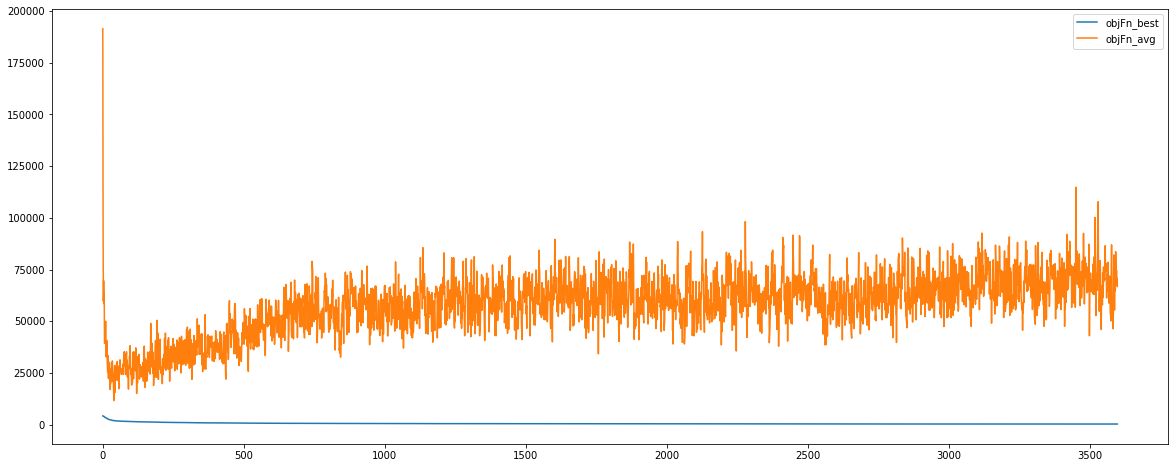

In [40]:
objFn_evolution.plot(figsize=(20, 8))